In [1]:
import cv2
import numpy as np
from sklearn.utils import shuffle
import zipfile
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
DOWNLOAD_PATH = "./data/temp/"
DATA_PATH = "./data"
ZIP_NAME = "fer2013.zip"
TEMP_ZIP_FILE_PATH = os.path.join(DOWNLOAD_PATH, ZIP_NAME)
TRAIN_PATH = os.path.join(DATA_PATH, "train")
TEST_PATH = os.path.join(DATA_PATH, "test")

In [3]:
os.makedirs(DOWNLOAD_PATH, exist_ok=True)

!curl -L -o {TEMP_ZIP_FILE_PATH} https://www.kaggle.com/api/v1/datasets/download/msambare/fer2013

with zipfile.ZipFile(TEMP_ZIP_FILE_PATH, "r") as zip:
    zip.extractall(DATA_PATH)

os.remove(TEMP_ZIP_FILE_PATH)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 60.3M  100 60.3M    0     0  3821k      0  0:00:16  0:00:16 --:--:-- 4173k


In [3]:
def load_dataset(PATH):
    CLASS_NAMES = sorted(os.listdir(PATH))
    CLASS_NAMES.remove("disgust")
    LABEL_MAP = {name: idx for idx, name in enumerate(CLASS_NAMES)}
    
    images = []
    labels = []
    
    for class_name in CLASS_NAMES:
        class_dir = os.path.join(PATH, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                images.append(img)
                labels.append(LABEL_MAP[class_name])
    images = np.array(images)
    labels = np.array(labels)
    images, labels = shuffle(images, labels, random_state=42)
    return images, labels, LABEL_MAP

In [4]:
X_train, y_train, LABEL_MAP = load_dataset(TRAIN_PATH)
X_test, y_test, _ = load_dataset(TEST_PATH)

X_train.shape, y_train.shape, LABEL_MAP

((28273, 48, 48, 3),
 (28273,),
 {'angry': 0, 'fear': 1, 'happy': 2, 'neutral': 3, 'sad': 4, 'surprise': 5})

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization

def create_cnn_model(base_model, OUTPUT_SIZE):
    base_model.trainable = False
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(256, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    predictions = Dense(OUTPUT_SIZE, activation="softmax")(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model

2025-08-15 08:15:28.591380: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-15 08:15:28.642606: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-15 08:15:30.007172: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [34]:
import os
import matplotlib.pyplot as plt

def show_train_loss_accuracy(history, model_name):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].plot(history.history['loss'], label='Loss Treino')
    axes[0].plot(history.history['val_loss'], label='Loss Validação')
    axes[0].set_title(f'Loss - {model_name}')
    axes[0].set_xlabel('Época')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    if 'accuracy' in history.history:
        axes[1].plot(history.history['accuracy'], label='Acurácia Treino')
        axes[1].plot(history.history['val_accuracy'], label='Acurácia Validação')
        axes[1].set_title(f'Acurácia - {model_name}')
        axes[1].set_xlabel('Época')
        axes[1].set_ylabel('Acurácia')
        axes[1].legend()
    else:
        axes[1].axis('off')
        axes[1].text(0.5, 0.5, 'Acurácia não disponível', ha='center', va='center')

    plt.tight_layout()

    save_dir = os.path.join(model_name, "metrics", "training")
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, "accuracy_loss_plot_flatten_sem_nojo.png")
    
    plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()


In [7]:
from tensorflow.keras.applications import VGG19, DenseNet201, ResNet50V2

OUTPUT_CLASSES = 6
INPUT_SHAPE = (48, 48, 3)

def get_callbacks(model_name):
    return [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=3),
    ModelCheckpoint(f'{model_name}/best_{model_name}_no_disgust_flatten.keras', monitor='accuracy', save_best_only=True)
]


resnet50v2 = create_cnn_model(
    ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=INPUT_SHAPE,
    pooling=None,
    classes=OUTPUT_CLASSES,
    classifier_activation="softmax"
), OUTPUT_CLASSES)

denseNet201 = create_cnn_model(DenseNet201(
    include_top=False,
    weights="imagenet",
    input_shape=INPUT_SHAPE,
    pooling=None,
    classes=OUTPUT_CLASSES,
    classifier_activation="softmax"
), OUTPUT_CLASSES)

vgg19 = create_cnn_model(VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=INPUT_SHAPE,
    pooling=None,
    classes=OUTPUT_CLASSES,
    classifier_activation="softmax"
), OUTPUT_CLASSES)

models = {
    "ResNet50v2": resnet50v2,
    "DenseNet201": denseNet201,
    "VGG19": vgg19,
    
}

2025-08-15 08:15:30.258456: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [8]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

BATCH_SIZE = 32
EPOCHS = 60
histories = {}

# Normaliza
X_train_resized = X_train.astype("float32") / 255.0
X_test_resized = X_test.astype("float32") / 255.0

# One-hot
y_train_cat = to_categorical(y_train, num_classes=OUTPUT_CLASSES)
y_test_cat = to_categorical(y_test, num_classes=OUTPUT_CLASSES)

for model_name, model in models.items():
    print(f"STRAT TRAINING MODEL {model_name}...")
    histories[model_name] = model.fit(X_train_resized, y_train_cat,
                                     validation_split=0.2,
                                     epochs=EPOCHS,
                                     batch_size=BATCH_SIZE,
                                     callbacks=get_callbacks(model_name))
    print(f"FINISH TRAINING MODEL {model_name}!")
    print("---------------------------------------------------------------")

STRAT TRAINING MODEL ResNet50v2...
Epoch 1/60


2025-08-15 08:15:39.021568: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 625342464 exceeds 10% of free system memory.


707/707 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.2267 - loss: 2.4380

2025-08-15 08:16:43.218395: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 156349440 exceeds 10% of free system memory.


707/707 ━━━━━━━━━━━━━━━━━━━━ 87s 113ms/step - accuracy: 0.2521 - loss: 2.2846 - val_accuracy: 0.3498 - val_loss: 1.6736 - learning_rate: 1.0000e-04
Epoch 2/60
707/707 ━━━━━━━━━━━━━━━━━━━━ 96s 136ms/step - accuracy: 0.3015 - loss: 1.9638 - val_accuracy: 0.3728 - val_loss: 1.6008 - learning_rate: 1.0000e-04
Epoch 3/60
707/707 ━━━━━━━━━━━━━━━━━━━━ 96s 136ms/step - accuracy: 0.3295 - loss: 1.8303 - val_accuracy: 0.3878 - val_loss: 1.5604 - learning_rate: 1.0000e-04
Epoch 4/60
707/707 ━━━━━━━━━━━━━━━━━━━━ 98s 138ms/step - accuracy: 0.3502 - loss: 1.7286 - val_accuracy: 0.3910 - val_loss: 1.5474 - learning_rate: 1.0000e-04
Epoch 5/60
707/707 ━━━━━━━━━━━━━━━━━━━━ 136s 129ms/step - accuracy: 0.3598 - loss: 1.6688 - val_accuracy: 0.3963 - val_loss: 1.5338 - learning_rate: 1.0000e-04
Epoch 6/60
707/707 ━━━━━━━━━━━━━━━━━━━━ 66s 94ms/step - accuracy: 0.3822 - loss: 1.6034 - val_accuracy: 0.3981 - val_loss: 1.5186 - learning_rate: 1.0000e-04
Epoch 7/60
707/707 ━━━━━━━━━━━━━━━━━━━━ 100s 141ms/step -

2025-08-15 08:57:11.304867: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 625342464 exceeds 10% of free system memory.


707/707 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.2303 - loss: 2.4617

2025-08-15 08:59:30.246256: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 156349440 exceeds 10% of free system memory.


707/707 ━━━━━━━━━━━━━━━━━━━━ 179s 207ms/step - accuracy: 0.2635 - loss: 2.2945 - val_accuracy: 0.3698 - val_loss: 1.6327 - learning_rate: 1.0000e-04
Epoch 2/60
707/707 ━━━━━━━━━━━━━━━━━━━━ 143s 202ms/step - accuracy: 0.3188 - loss: 1.9479 - val_accuracy: 0.3938 - val_loss: 1.5634 - learning_rate: 1.0000e-04
Epoch 3/60
707/707 ━━━━━━━━━━━━━━━━━━━━ 147s 208ms/step - accuracy: 0.3459 - loss: 1.8116 - val_accuracy: 0.4064 - val_loss: 1.5217 - learning_rate: 1.0000e-04
Epoch 4/60
707/707 ━━━━━━━━━━━━━━━━━━━━ 142s 200ms/step - accuracy: 0.3627 - loss: 1.7206 - val_accuracy: 0.4161 - val_loss: 1.4891 - learning_rate: 1.0000e-04
Epoch 5/60
707/707 ━━━━━━━━━━━━━━━━━━━━ 142s 201ms/step - accuracy: 0.3725 - loss: 1.6534 - val_accuracy: 0.4134 - val_loss: 1.4780 - learning_rate: 1.0000e-04
Epoch 6/60
707/707 ━━━━━━━━━━━━━━━━━━━━ 142s 200ms/step - accuracy: 0.3911 - loss: 1.5913 - val_accuracy: 0.4223 - val_loss: 1.4615 - learning_rate: 1.0000e-04
Epoch 7/60
707/707 ━━━━━━━━━━━━━━━━━━━━ 156s 221ms/

2025-08-15 09:58:11.610283: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 625342464 exceeds 10% of free system memory.


707/707 ━━━━━━━━━━━━━━━━━━━━ 179s 247ms/step - accuracy: 0.2454 - loss: 2.3099 - val_accuracy: 0.3438 - val_loss: 1.6559 - learning_rate: 1.0000e-04
Epoch 2/60
707/707 ━━━━━━━━━━━━━━━━━━━━ 165s 234ms/step - accuracy: 0.2937 - loss: 2.0108 - val_accuracy: 0.3699 - val_loss: 1.5911 - learning_rate: 1.0000e-04
Epoch 3/60
707/707 ━━━━━━━━━━━━━━━━━━━━ 232s 328ms/step - accuracy: 0.3087 - loss: 1.8852 - val_accuracy: 0.3758 - val_loss: 1.5607 - learning_rate: 1.0000e-04
Epoch 4/60
707/707 ━━━━━━━━━━━━━━━━━━━━ 262s 328ms/step - accuracy: 0.3192 - loss: 1.7996 - val_accuracy: 0.3935 - val_loss: 1.5424 - learning_rate: 1.0000e-04
Epoch 5/60
707/707 ━━━━━━━━━━━━━━━━━━━━ 331s 425ms/step - accuracy: 0.3308 - loss: 1.7398 - val_accuracy: 0.3956 - val_loss: 1.5341 - learning_rate: 1.0000e-04
Epoch 6/60
707/707 ━━━━━━━━━━━━━━━━━━━━ 291s 381ms/step - accuracy: 0.3433 - loss: 1.6945 - val_accuracy: 0.3927 - val_loss: 1.5217 - learning_rate: 1.0000e-04
Epoch 7/60
707/707 ━━━━━━━━━━━━━━━━━━━━ 255s 361ms/

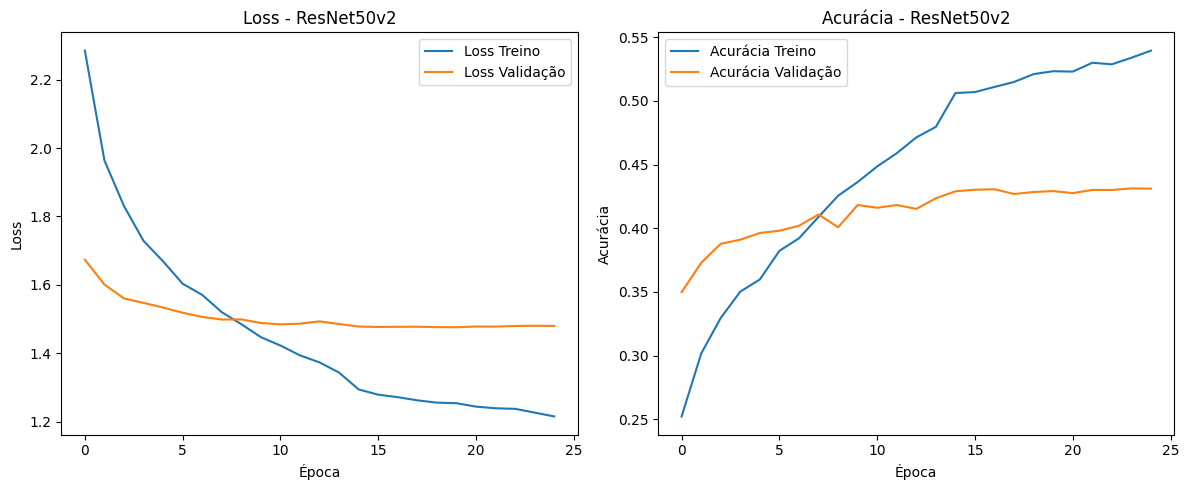

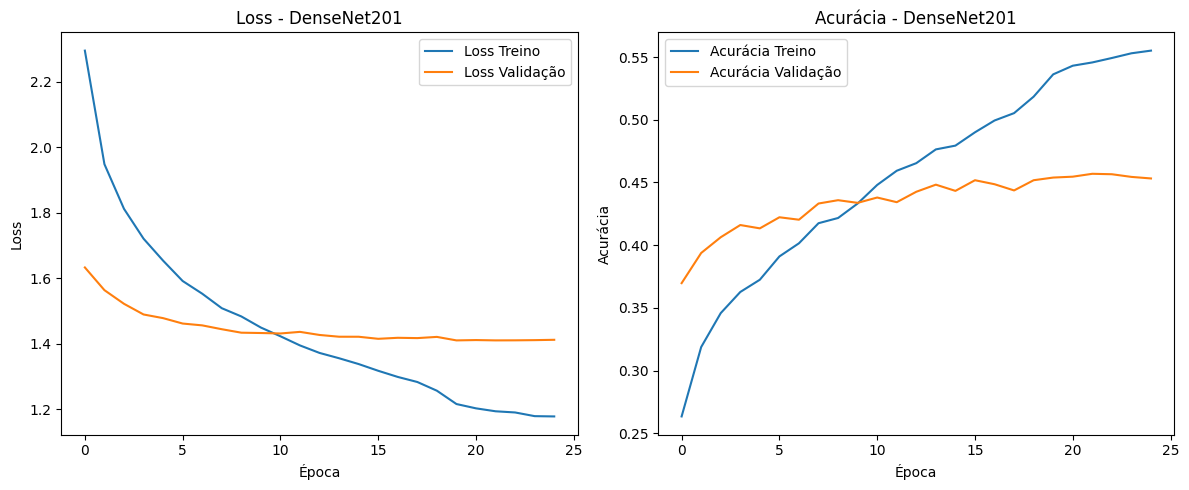

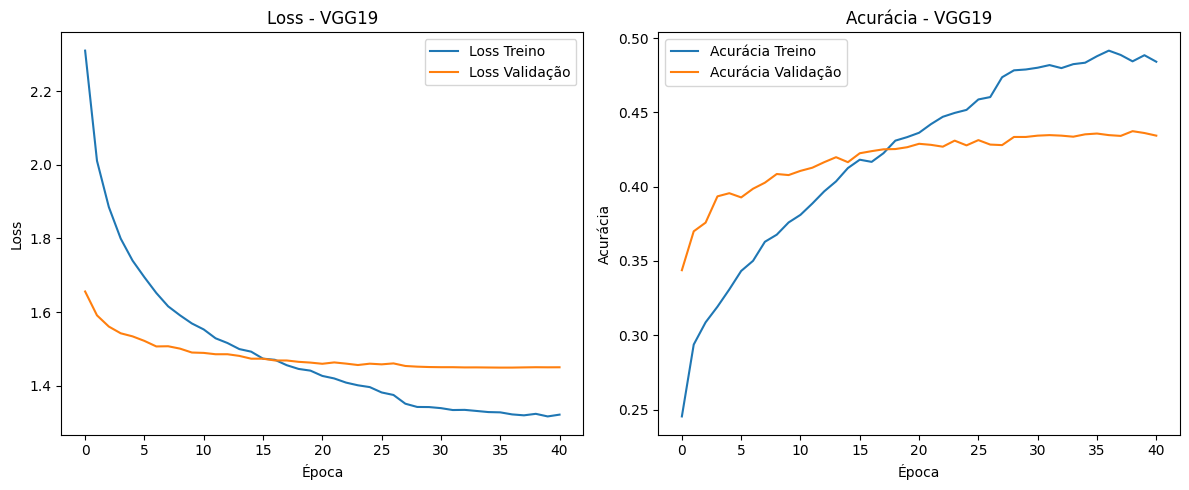

In [35]:
for model_name, history in histories.items():
    show_train_loss_accuracy(history, model_name)

In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix
)

def show_metrics(y_true, y_pred, model_name, is_test=False):
    classes_emocao = list(LABEL_MAP.keys())
    class_acc = {}

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro')
    rec = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    print(f"Métricas do modelo: {model_name}")
    print("Accuracy Score:  ", round(acc, 4))
    print("Precision Score: ", round(prec, 4))
    print("Recall Score:    ", round(rec, 4))
    print("F1 Score:        ", round(f1, 4))
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred))
    
    for i, emotion in enumerate(classes_emocao):
        idx = np.where(y_true == i)[0]
        correct = np.sum(y_pred[idx] == y_true[idx])
        class_acc[emotion] = correct / len(idx)
    
    print('\nAcurácia por classe:')
    for emotion, acc in class_acc.items():
        print(f'- {emotion}: {acc:.2%}')

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes_emocao, 
                yticklabels=classes_emocao)
    plt.title(f'Matriz de Confusão - {model_name}')
    plt.ylabel('Verdadeiro')
    plt.xlabel('Predito')

    save_dir = os.path.join(model_name, "metrics", "flatten")
    os.makedirs(save_dir, exist_ok=True)

    save_path = os.path.join(save_dir, f"{"test_" if is_test else "train_"}confusion_matrix_sem_nojo.jpg")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

In [11]:
def get_preds(X, model):
    y = model.predict(X)
    return np.argmax(y, axis=1)

In [12]:
y_preds = {}
for model_name, model in models.items():
    y_preds[model_name] = get_preds(X_train_resized, model)

884/884 ━━━━━━━━━━━━━━━━━━━━ 184s 206ms/step
884/884 ━━━━━━━━━━━━━━━━━━━━ 385s 425ms/step
884/884 ━━━━━━━━━━━━━━━━━━━━ 231s 260ms/step


Métricas do modelo: ResNet50v2
Accuracy Score:   0.5802
Precision Score:  0.5793
Recall Score:     0.563
F1 Score:         0.5665

Classification Report:

              precision    recall  f1-score   support

           0       0.52      0.48      0.50      3995
           1       0.59      0.40      0.48      4097
           2       0.61      0.77      0.68      7215
           3       0.54      0.54      0.54      4965
           4       0.56      0.51      0.53      4830
           5       0.67      0.68      0.67      3171

    accuracy                           0.58     28273
   macro avg       0.58      0.56      0.57     28273
weighted avg       0.58      0.58      0.57     28273


Acurácia por classe:
- angry: 48.11%
- fear: 40.25%
- happy: 76.78%
- neutral: 54.10%
- sad: 50.99%
- surprise: 67.58%


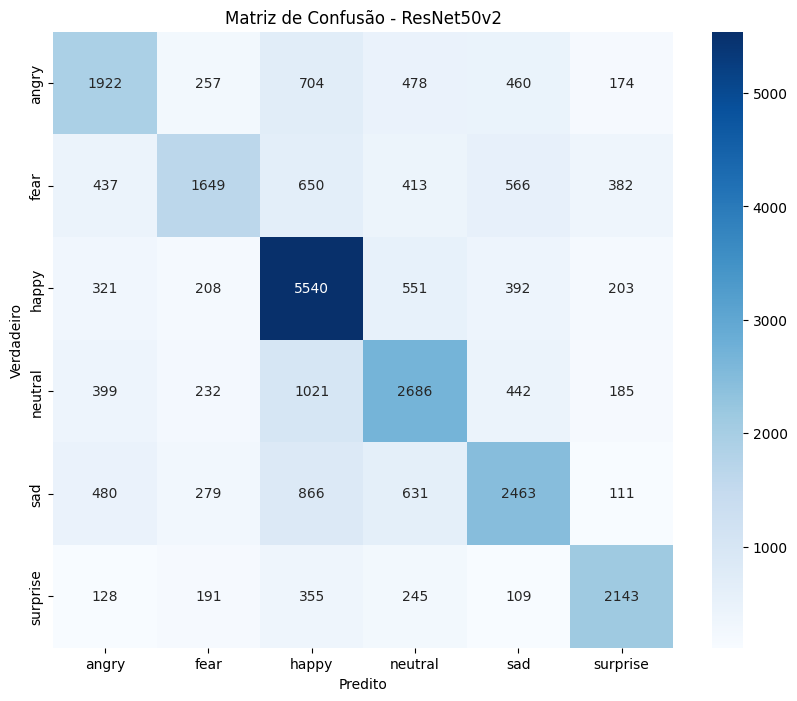

Métricas do modelo: DenseNet201
Accuracy Score:   0.5991
Precision Score:  0.6085
Recall Score:     0.5788
F1 Score:         0.5862

Classification Report:

              precision    recall  f1-score   support

           0       0.58      0.47      0.52      3995
           1       0.62      0.43      0.51      4097
           2       0.61      0.81      0.69      7215
           3       0.53      0.59      0.56      4965
           4       0.57      0.49      0.53      4830
           5       0.74      0.69      0.71      3171

    accuracy                           0.60     28273
   macro avg       0.61      0.58      0.59     28273
weighted avg       0.60      0.60      0.59     28273


Acurácia por classe:
- angry: 46.71%
- fear: 42.59%
- happy: 80.97%
- neutral: 58.63%
- sad: 49.46%
- surprise: 68.91%


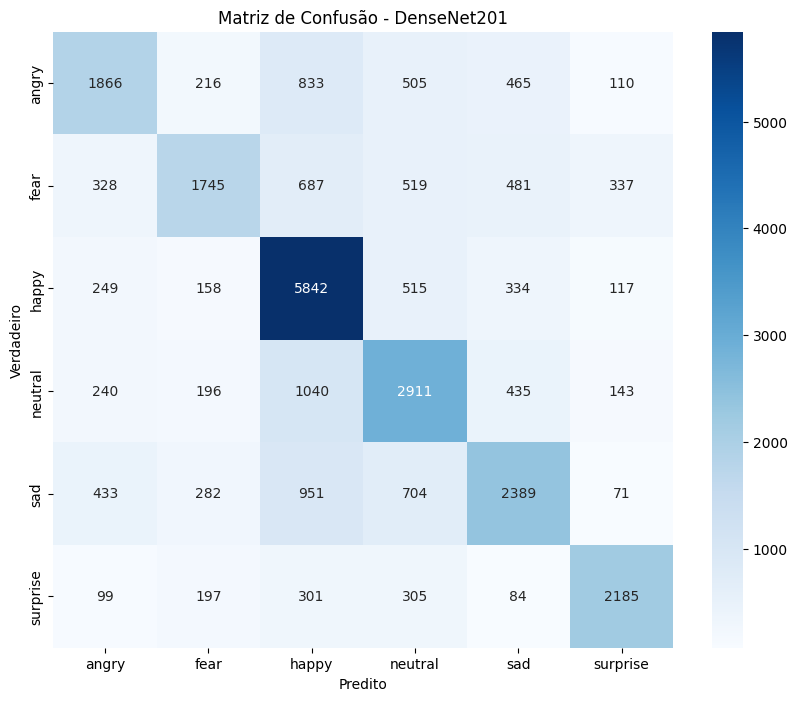

Métricas do modelo: VGG19
Accuracy Score:   0.5329
Precision Score:  0.5422
Recall Score:     0.5153
F1 Score:         0.5219

Classification Report:

              precision    recall  f1-score   support

           0       0.52      0.40      0.45      3995
           1       0.54      0.36      0.44      4097
           2       0.53      0.74      0.62      7215
           3       0.50      0.49      0.49      4965
           4       0.46      0.44      0.45      4830
           5       0.70      0.65      0.68      3171

    accuracy                           0.53     28273
   macro avg       0.54      0.52      0.52     28273
weighted avg       0.53      0.53      0.53     28273


Acurácia por classe:
- angry: 40.33%
- fear: 36.47%
- happy: 73.80%
- neutral: 48.62%
- sad: 44.45%
- surprise: 65.50%


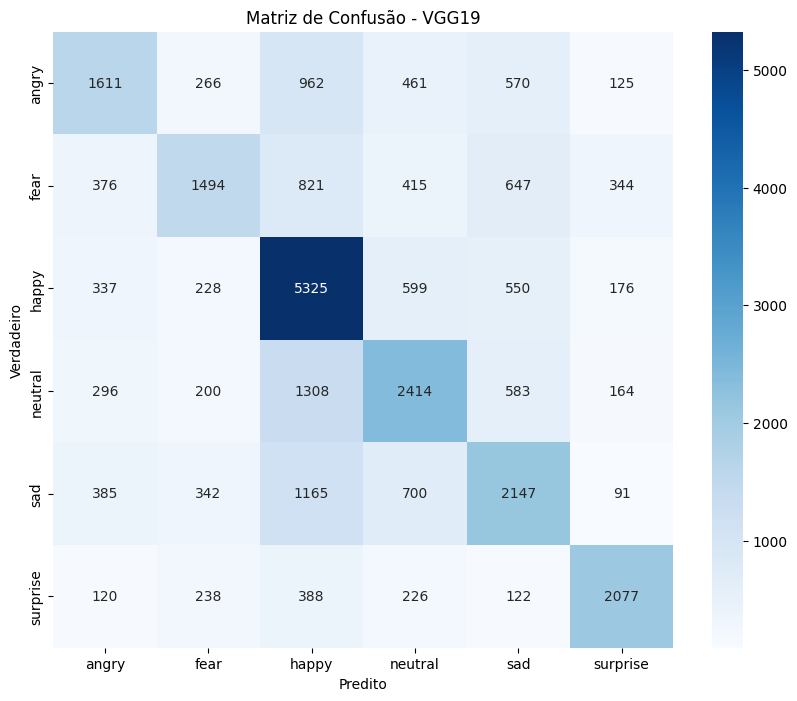

In [21]:
metrics = {}
for model_name, preds in y_preds.items():
    metrics[model_name] = show_metrics(y_train, preds, model_name)

In [14]:
y_preds_teste = {}
for model_name, model in models.items():
    y_preds_teste[model_name] = get_preds(X_test_resized, model)

221/221 ━━━━━━━━━━━━━━━━━━━━ 45s 202ms/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 94s 424ms/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 66s 300ms/step


Métricas do modelo: ResNet50v2
Accuracy Score:   0.4401
Precision Score:  0.4248
Recall Score:     0.421
F1 Score:         0.4197

Classification Report:

              precision    recall  f1-score   support

           0       0.32      0.32      0.32       958
           1       0.34      0.24      0.28      1024
           2       0.52      0.66      0.58      1774
           3       0.39      0.39      0.39      1233
           4       0.38      0.35      0.36      1247
           5       0.58      0.57      0.58       831

    accuracy                           0.44      7067
   macro avg       0.42      0.42      0.42      7067
weighted avg       0.43      0.44      0.43      7067


Acurácia por classe:
- angry: 32.15%
- fear: 23.54%
- happy: 66.12%
- neutral: 39.09%
- sad: 34.56%
- surprise: 57.16%


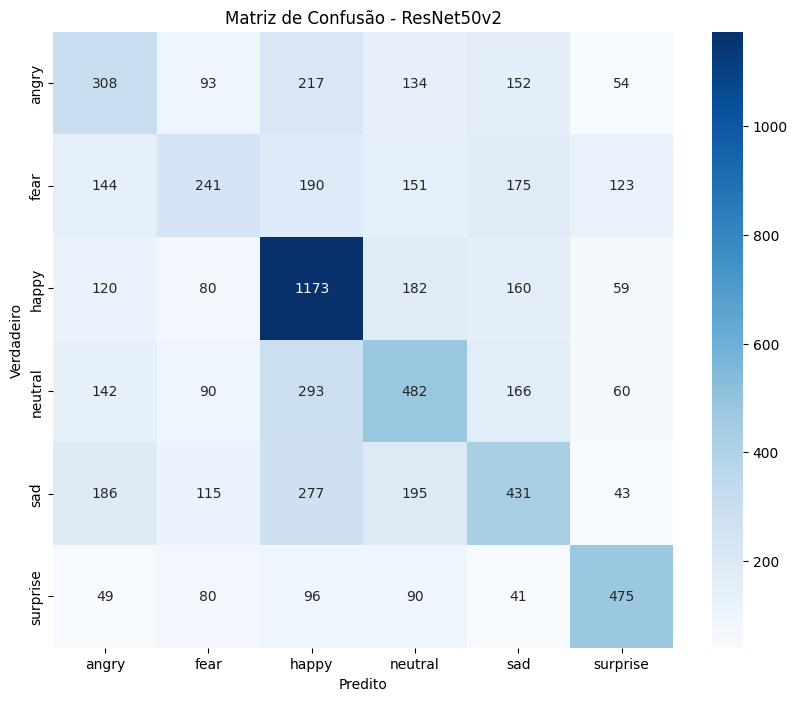

Métricas do modelo: DenseNet201
Accuracy Score:   0.4613
Precision Score:  0.4526
Recall Score:     0.4383
F1 Score:         0.4393

Classification Report:

              precision    recall  f1-score   support

           0       0.38      0.31      0.34       958
           1       0.39      0.26      0.31      1024
           2       0.52      0.71      0.60      1774
           3       0.39      0.44      0.41      1233
           4       0.41      0.34      0.37      1247
           5       0.62      0.57      0.59       831

    accuracy                           0.46      7067
   macro avg       0.45      0.44      0.44      7067
weighted avg       0.45      0.46      0.45      7067


Acurácia por classe:
- angry: 31.32%
- fear: 25.98%
- happy: 70.57%
- neutral: 43.96%
- sad: 34.24%
- surprise: 56.92%


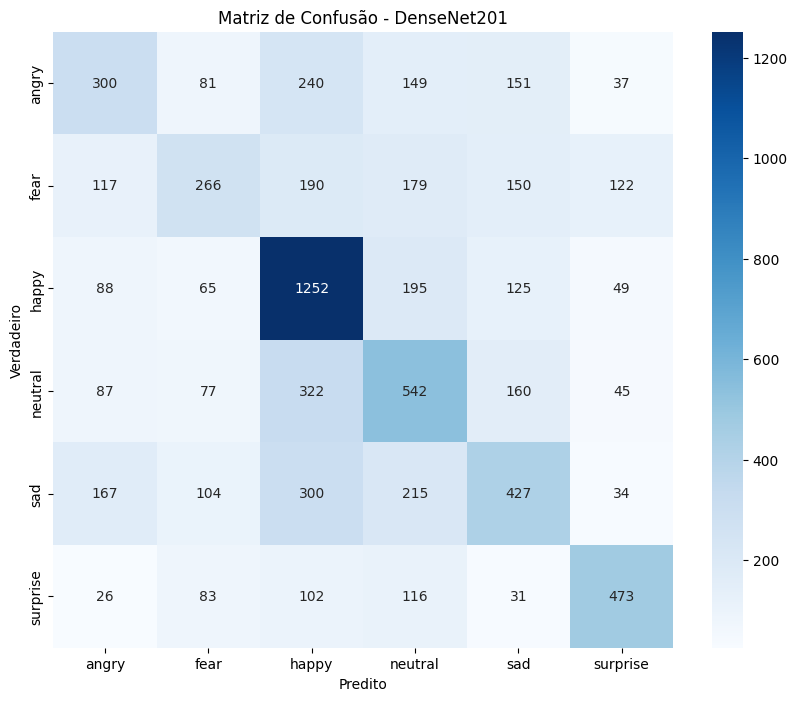

Métricas do modelo: VGG19
Accuracy Score:   0.4368
Precision Score:  0.4319
Recall Score:     0.4172
F1 Score:         0.4189

Classification Report:

              precision    recall  f1-score   support

           0       0.36      0.28      0.32       958
           1       0.38      0.25      0.30      1024
           2       0.47      0.66      0.55      1774
           3       0.39      0.39      0.39      1233
           4       0.37      0.34      0.35      1247
           5       0.62      0.57      0.60       831

    accuracy                           0.44      7067
   macro avg       0.43      0.42      0.42      7067
weighted avg       0.43      0.44      0.43      7067


Acurácia por classe:
- angry: 28.29%
- fear: 25.10%
- happy: 66.01%
- neutral: 39.50%
- sad: 34.00%
- surprise: 57.40%


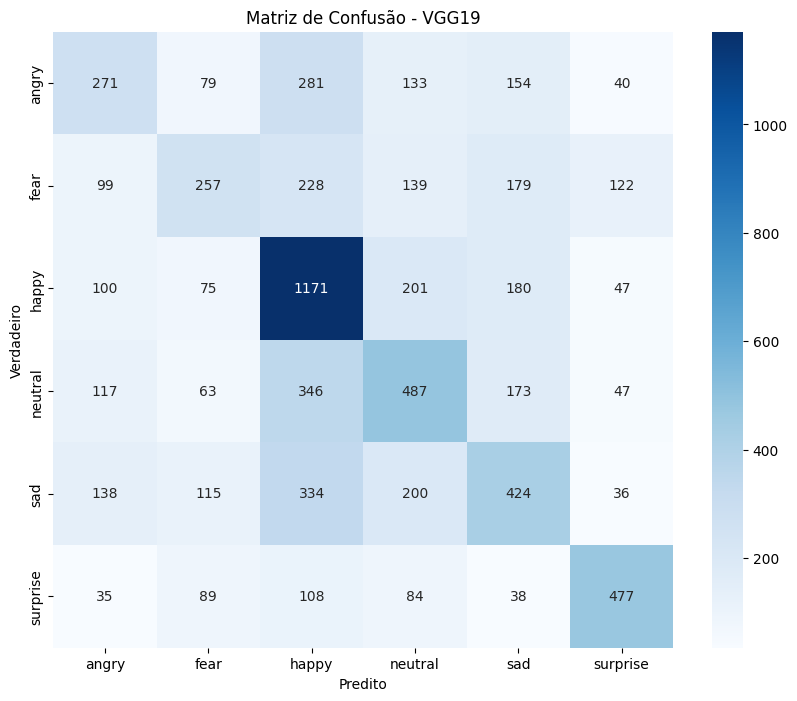

In [22]:
metrics_teste = {}
for model_name, preds in y_preds_teste.items():
    metrics_teste[model_name] = show_metrics(y_test, preds, model_name, is_test=True)